In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import warnings
import numpy as np
warnings.filterwarnings('ignore')

In [2]:
imdb_sentences = []
imdb_labels = []

In [3]:
train_data = tfds.as_numpy(tfds.load('imdb_reviews', split='train'))
len(train_data)

25000

In [4]:
for item in train_data:
    imdb_labels.append(item['label'])
    imdb_sentences.append(str(item['text']))

In [5]:
len(imdb_sentences), len(imdb_labels)

(25000, 25000)

In [6]:
training_sentences = imdb_sentences[:20000]
test_sentences = imdb_sentences[20000:]

training_label = imdb_labels[:20000]
test_label = imdb_labels[20000:]

In [7]:
len(training_sentences), len(test_sentences)

(20000, 5000)

In [8]:
type(imdb_sentences[25])

str

# Tokenisation (phrase -> liste de mot)

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(oov_token="<OOV>")

In [11]:
phrase = ["I love climbing"]
tokenizer.fit_on_texts(phrase)
print(tokenizer.word_index)
print(tokenizer.texts_to_sequences(phrase))

{'<OOV>': 1, 'i': 2, 'love': 3, 'climbing': 4}
[[2, 3, 4]]


# Padding

In [12]:
phrases = [
    "Je suis au marché à la ciotat",
    "J'aime les bananes",
    "j'ai étendu mon linges",
    "j'ai chargé ma voiture"
]

tokenizer = Tokenizer(num_words=100, oov_token="<OOV>")
tokenizer.fit_on_texts(phrases)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(phrases)

In [13]:
word_index

{'<OOV>': 1,
 "j'ai": 2,
 'je': 3,
 'suis': 4,
 'au': 5,
 'marché': 6,
 'à': 7,
 'la': 8,
 'ciotat': 9,
 "j'aime": 10,
 'les': 11,
 'bananes': 12,
 'étendu': 13,
 'mon': 14,
 'linges': 15,
 'chargé': 16,
 'ma': 17,
 'voiture': 18}

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
print(pad_sequences(sequences))

[[ 3  4  5  6  7  8  9]
 [ 0  0  0  0 10 11 12]
 [ 0  0  0  2 13 14 15]
 [ 0  0  0  2 16 17 18]]


In [16]:
print(pad_sequences(sequences, padding="post"))

[[ 3  4  5  6  7  8  9]
 [10 11 12  0  0  0  0]
 [ 2 13 14 15  0  0  0]
 [ 2 16 17 18  0  0  0]]


In [17]:
print(pad_sequences(sequences, padding="post", maxlen=5))

[[ 5  6  7  8  9]
 [10 11 12  0  0]
 [ 2 13 14 15  0]
 [ 2 16 17 18  0]]


In [18]:
print(pad_sequences(sequences, padding="post", maxlen=5, truncating="post"))

[[ 3  4  5  6  7]
 [10 11 12  0  0]
 [ 2 13 14 15  0]
 [ 2 16 17 18  0]]


# Stop words (mot qu'on peux delete, pcq trop nombreux)

In [19]:
phrase = ["Je vais au course le jeudi"]
stopword = ["au, le"]
clean_phrase = ["Je vais course jeudi"]

# Embedding (chaque mot sous forme de vecteur)


In [20]:
training_sentences[42]

'b\'One of the weaker Carry On adventures sees Sid James as the head of a crime gang stealing contraceptive pills. The fourth of the series to be hospital-based, it\\\'s possibly the least of the genre. There\\\'s a curiously flat feel throughout, with all seemingly squandered on below-par material. This is far from the late-70s nadir, but Williams, James, Bresslaw, Maynard et al. are all class performers yet not given the backing of a script equal to their ability.<br /><br />Most of the gags are onrunning, rather than episodic as Carry Ons usually are. So that instead of the traditional hit and miss ratio, if you don\\\'t find the joke funny in the first place you\\\'re stuck with it for most of the film. These continuous plot strands include Williams \\xc2\\x96 for no good reason \\xc2\\x96 worrying that he\\\'s changing sex, and Kenneth Cope in drag. Like the stagy physical pratt falls, the whole thing feels more contrived than in other movies, and lacking in cast interest. Continu

In [21]:
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, padding="post", maxlen=15, truncating="post")

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding="post", maxlen=15, truncating="post")

In [22]:
len(tokenizer.word_index)

78371

In [23]:
training_label = np.array(training_label)
test_label = np.array(test_label)

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(20000, 20),
    tf.keras.layers.GlobalAvgPool1D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')

])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          400000    
                                                                 
 global_average_pooling1d (  (None, 20)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 8)                 168       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 400177 (1.53 MB)
Trainable params: 400177 (1.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [27]:
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath="best_model.h5",
                            monitor="val_accuracy",
                            mode="max",
                            save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True)

In [28]:
h = model.fit(training_padded, training_label, epochs=50,
              validation_data=(test_padded, test_label),
              callbacks=[model_ckp])

Epoch 1/50



625/625 [==============================] - 2s 2ms/step - loss: 0.6496 - accuracy: 0.6244 - val_loss: 0.5974 - val_accuracy: 0.6854
Epoch 2/50
625/625 [==============================] - 1s 2ms/step - loss: 0.5074 - accuracy: 0.7559 - val_loss: 0.5809 - val_accuracy: 0.6986
Epoch 3/50
625/625 [==============================] - 1s 2ms/step - loss: 0.4248 - accuracy: 0.8101 - val_loss: 0.6105 - val_accuracy: 0.6966
Epoch 4/50
625/625 [==============================] - 1s 2ms/step - loss: 0.3733 - accuracy: 0.8386 - val_loss: 0.6520 - val_accuracy: 0.6956
Epoch 5/50
625/625 [==============================] - 3s 4ms/step - loss: 0.3365 - accuracy: 0.8569 - val_loss: 0.6931 - val_accuracy: 0.6858
Epoch 6/50
625/625 [==============================] - 4s 6ms/step - loss: 0.3096 - accuracy: 0.8710 - val_loss: 0.7470 - val_accuracy: 0.6826
Epoch 7/50
625/625 [==============================] - 3s 5ms/step - loss: 0.2886 - accuracy: 0.8804 - val_loss: 0.7962 - val_accuracy: 0.6784
Epoch 8/50
625/62

In [29]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

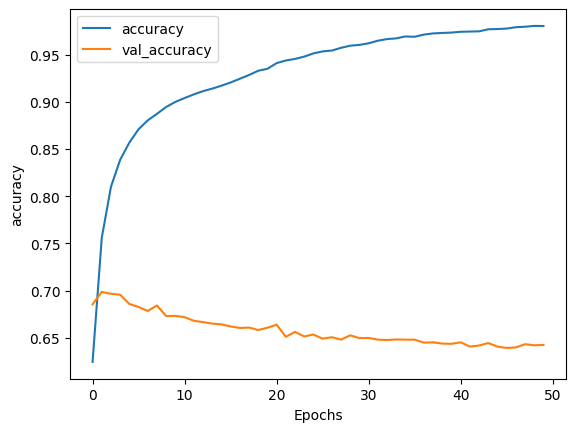

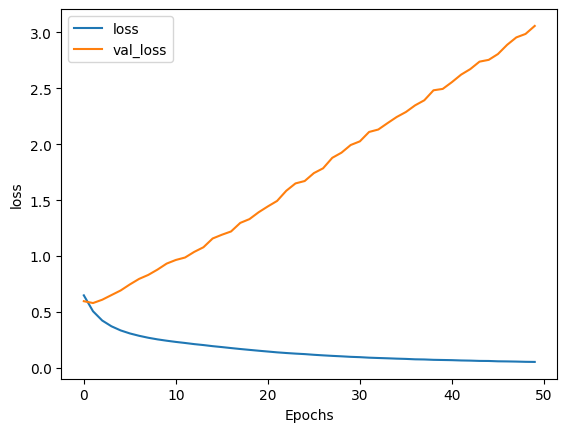

In [30]:
plot_graphs(h, 'accuracy')
plot_graphs(h, 'loss')
# overfitting !!!!!

# Vocab size

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 20)          1400000   
                                                                 
 global_average_pooling1d_1  (None, 20)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 8)                 168       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1400177 (5.34 MB)
Trainable params: 1400177 (5.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
625/625 [==============================] - 5s 7ms/step - loss: 0.6460 -

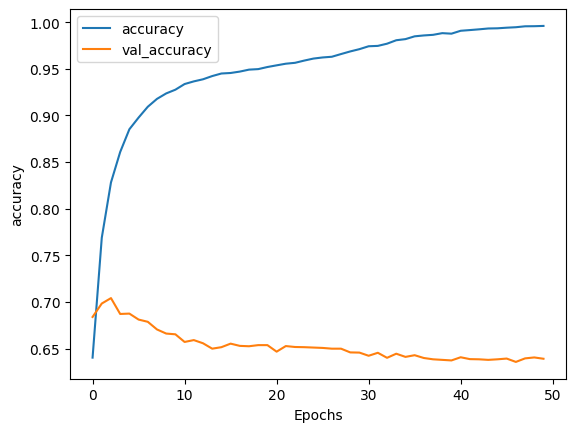

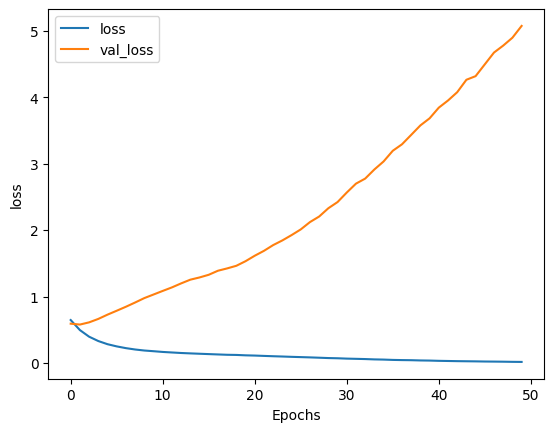

In [31]:
tokenizer = Tokenizer(num_words=70000, oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, padding="post", maxlen=15, truncating="post")

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding="post", maxlen=15, truncating="post")
len(tokenizer.word_index)
training_label = np.array(training_label)
test_label = np.array(test_label)
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(70000, 20),
    tf.keras.layers.GlobalAvgPool1D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')

])
model.summary()
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath="best_model.h5",
                                               monitor="val_accuracy",
                                               mode="max",
                                               save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True)
h = model.fit(training_padded, training_label, epochs=50,
              validation_data=(test_padded, test_label),
              callbacks=[model_ckp])

plot_graphs(h, 'accuracy')
plot_graphs(h, 'loss')

In [32]:
import pandas as pd

In [33]:
wc = tokenizer.word_counts

In [34]:
wc = sorted(wc.items(), key=lambda t:t[1], reverse=True)

In [35]:
df = pd.DataFrame(wc, columns=["mots", "freq"])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 20)          580000    
                                                                 
 global_average_pooling1d_2  (None, 20)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_4 (Dense)             (None, 8)                 168       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 580177 (2.21 MB)
Trainable params: 580177 (2.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
625/625 [==============================] - 2s 2ms/step - loss: 0.6412 - a

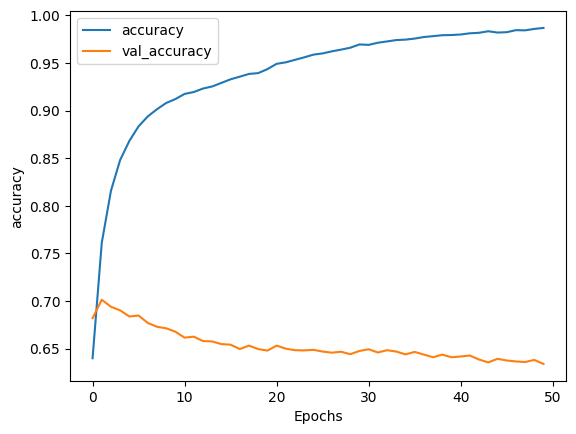

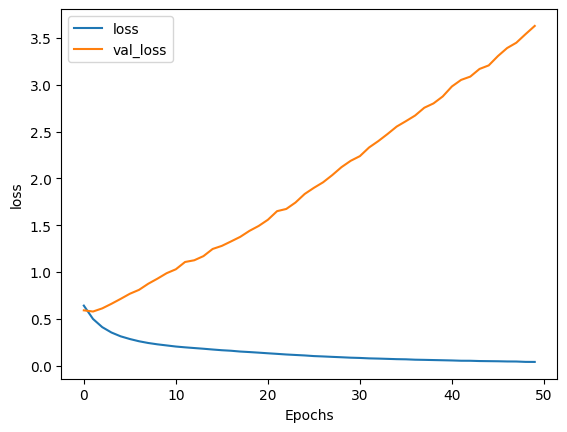

In [36]:
tokenizer = Tokenizer(num_words=29000, oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, padding="post", maxlen=15, truncating="post")

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding="post", maxlen=15, truncating="post")
len(tokenizer.word_index)
training_label = np.array(training_label)
test_label = np.array(test_label)
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(29000, 20),
    tf.keras.layers.GlobalAvgPool1D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')

])
model.summary()
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath="best_model.h5",
                                               monitor="val_accuracy",
                                               mode="max",
                                               save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True)
h = model.fit(training_padded, training_label, epochs=50,
              validation_data=(test_padded, test_label),
              callbacks=[model_ckp])

plot_graphs(h, 'accuracy')
plot_graphs(h, 'loss')

# Embedding dimensions

In [37]:
# (prendre la racine quatrième du vocab size) racine(racine(30000)) = 13

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 13)          377000    
                                                                 
 global_average_pooling1d_3  (None, 13)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_6 (Dense)             (None, 8)                 112       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 377121 (1.44 MB)
Trainable params: 377121 (1.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
625/625 [==============================] - 2s 2ms/step - loss: 0.6505 - a

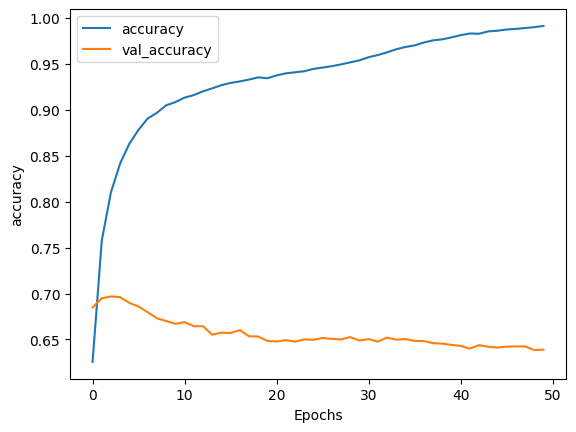

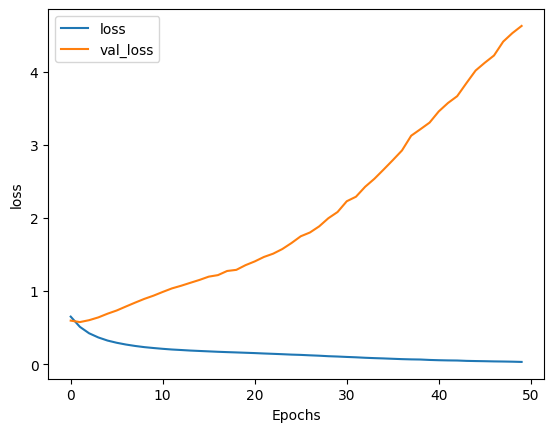

In [38]:
tokenizer = Tokenizer(num_words=29000, oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, padding="post", maxlen=15, truncating="post")

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding="post", maxlen=15, truncating="post")
len(tokenizer.word_index)
training_label = np.array(training_label)
test_label = np.array(test_label)
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(29000, 13),
    tf.keras.layers.GlobalAvgPool1D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')

])
model.summary()
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath="best_model.h5",
                                               monitor="val_accuracy",
                                               mode="max",
                                               save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True)
h = model.fit(training_padded, training_label, epochs=50,
              validation_data=(test_padded, test_label),
              callbacks=[model_ckp])

plot_graphs(h, 'accuracy')
plot_graphs(h, 'loss')

# Architecture du modèle

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 20)          580000    
                                                                 
 global_average_pooling1d_4  (None, 20)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_8 (Dense)             (None, 5)                 105       
                                                                 
 dense_9 (Dense)             (None, 3)                 18        
                                                                 
 dense_10 (Dense)            (None, 1)                 4         
                                                                 
Total params: 580127 (2.21 MB)
Trainable params: 580127 (2.21 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

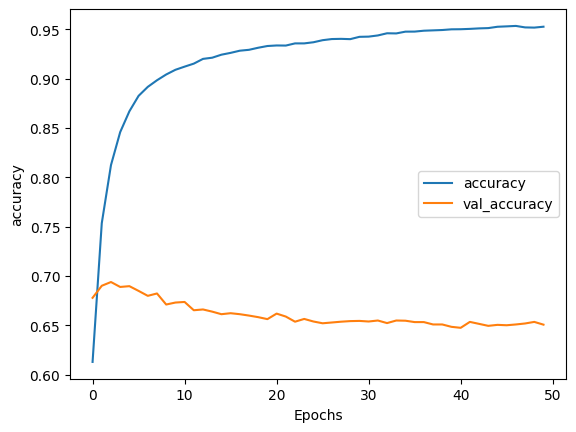

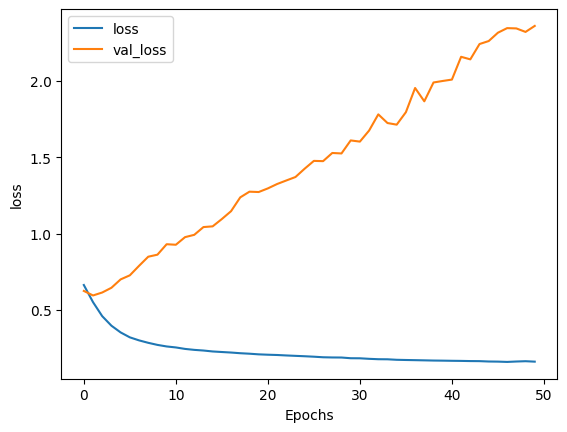

In [39]:
tokenizer = Tokenizer(num_words=29000, oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, padding="post", maxlen=15, truncating="post")

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding="post", maxlen=15, truncating="post")
len(tokenizer.word_index)
training_label = np.array(training_label)
test_label = np.array(test_label)

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(29000, 20),
    tf.keras.layers.GlobalAvgPool1D(),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')

])
model.summary()
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath="best_model.h5",
                                               monitor="val_accuracy",
                                               mode="max",
                                               save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True)
h = model.fit(training_padded, training_label, epochs=50,
              validation_data=(test_padded, test_label),
              callbacks=[model_ckp])

plot_graphs(h, 'accuracy')
plot_graphs(h, 'loss')

# Max length (taille max d'une phrase)

In [40]:
tailles = []
for sent in training_sentences:
    tailles.append(len(sent.split(" ")))

In [41]:
np.array(tailles).min(), np.array(tailles).max(), np.array(tailles).mean()

(10, 2470, 233.90165)

In [42]:
np.median(tailles)

174.0

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 13)          377000    
                                                                 
 global_average_pooling1d_5  (None, 13)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_11 (Dense)            (None, 5)                 70        
                                                                 
 dense_12 (Dense)            (None, 3)                 18        
                                                                 
 dense_13 (Dense)            (None, 1)                 4         
                                                                 
Total params: 377092 (1.44 MB)
Trainable params: 377092 (1.44 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

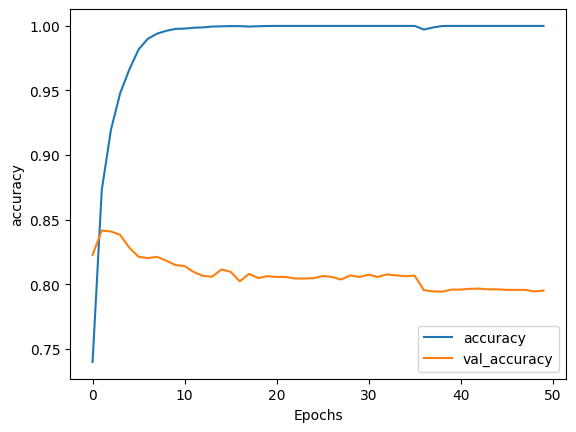

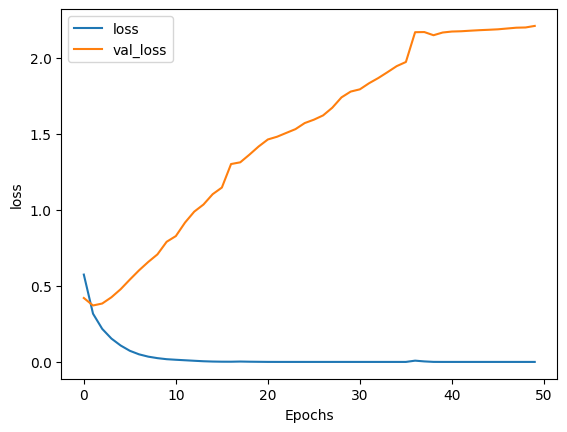

In [43]:
vocab_size = 29000
embedding_dim = 13
max_len = 100 # proche de la median

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, padding="post", maxlen=max_len, truncating="post")

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding="post", maxlen=max_len, truncating="post")
len(tokenizer.word_index)
training_label = np.array(training_label)
test_label = np.array(test_label)
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAvgPool1D(),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')

])
model.summary()
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath="best_model.h5",
                                               monitor="val_accuracy",
                                               mode="max",
                                               save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True)
h = model.fit(training_padded, training_label, epochs=50,
              validation_data=(test_padded, test_label),
              callbacks=[model_ckp])

plot_graphs(h, 'accuracy')
plot_graphs(h, 'loss')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 13)          377000    
                                                                 
 global_average_pooling1d_6  (None, 13)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_14 (Dense)            (None, 5)                 70        
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_15 (Dense)            (None, 3)                 18        
                                                                 
 dense_16 (Dense)            (None, 1)                 4         
                                                      

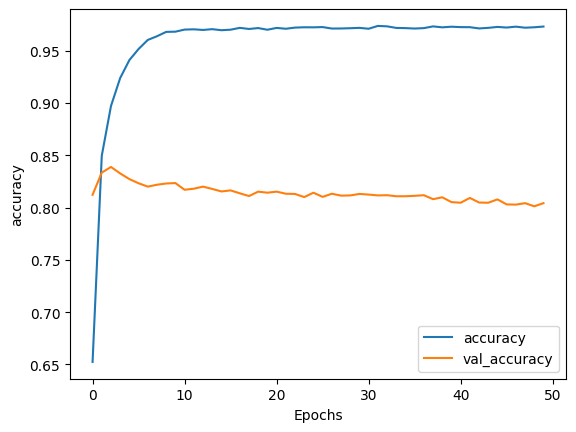

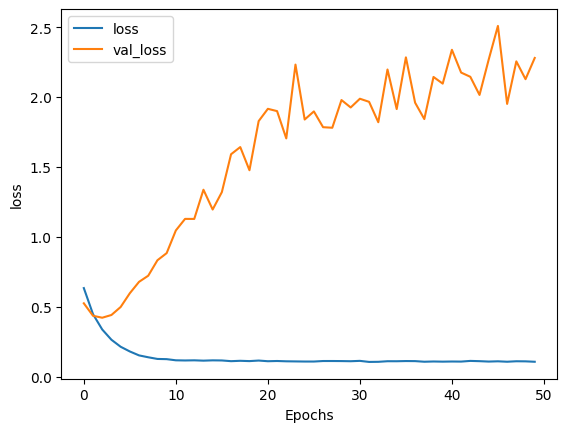

In [44]:
vocab_size = 29000
embedding_dim = 13
max_len = 100 # proche de la median

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, padding="post", maxlen=max_len, truncating="post")

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding="post", maxlen=max_len, truncating="post")
len(tokenizer.word_index)
training_label = np.array(training_label)
test_label = np.array(test_label)
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAvgPool1D(),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')

])
model.summary()
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath="best_model.h5",
                                               monitor="val_accuracy",
                                               mode="max",
                                               save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True)
h = model.fit(training_padded, training_label, epochs=50,
              validation_data=(test_padded, test_label),
              callbacks=[model_ckp])

plot_graphs(h, 'accuracy')
plot_graphs(h, 'loss')

# Transfert Learning

In [45]:
import tensorflow_hub as hub

In [ ]:
embed = hub.load("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1")
embeddings = embed(["cat is on the mat", "dog is in the fog"])



In [48]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", output_shape=[20],
                           input_shape=[], dtype=tf.string)


In [56]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"],
                                  batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)


training_sentences = train_examples[:20000]
training_labels = train_labels[:20000]

test_sentences = train_examples[20000:]
test_labels = train_labels[20000:]



In [57]:
model = tf.keras.models.Sequential([
    hub_layer,
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')

])
model.summary()
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath="best_model.h5",
                                               monitor="val_accuracy",
                                               mode="max",
                                               save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True)


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 20)                400020    
                                                                 
 dense_32 (Dense)            (None, 5)                 105       
                                                                 
 dropout_6 (Dropout)         (None, 5)                 0         
                                                                 
 dense_33 (Dense)            (None, 3)                 18        
                                                                 
 dense_34 (Dense)            (None, 1)                 4         
                                                                 
Total params: 400147 (1.53 MB)
Trainable params: 127 (508.00 Byte)
Non-trainable params: 400020 (1.53 MB)
_________________________________________________________________


Epoch 1/50
625/625 [==============================] - 2s 2ms/step - loss: 0.7174 - accuracy: 0.5464 - val_loss: 0.6632 - val_accuracy: 0.6074
Epoch 2/50
625/625 [==============================] - 1s 2ms/step - loss: 0.6609 - accuracy: 0.6061 - val_loss: 0.6355 - val_accuracy: 0.6454
Epoch 3/50
625/625 [==============================] - 1s 2ms/step - loss: 0.6397 - accuracy: 0.6406 - val_loss: 0.6231 - val_accuracy: 0.6694
Epoch 4/50
625/625 [==============================] - 1s 2ms/step - loss: 0.6270 - accuracy: 0.6531 - val_loss: 0.6032 - val_accuracy: 0.6876
Epoch 5/50
625/625 [==============================] - 1s 2ms/step - loss: 0.6189 - accuracy: 0.6566 - val_loss: 0.5952 - val_accuracy: 0.6904
Epoch 6/50
625/625 [==============================] - 1s 2ms/step - loss: 0.6136 - accuracy: 0.6633 - val_loss: 0.5841 - val_accuracy: 0.6964
Epoch 7/50
625/625 [==============================] - 1s 2ms/step - loss: 0.6077 - accuracy: 0.6701 - val_loss: 0.5851 - val_accuracy: 0.7008
Epoch 

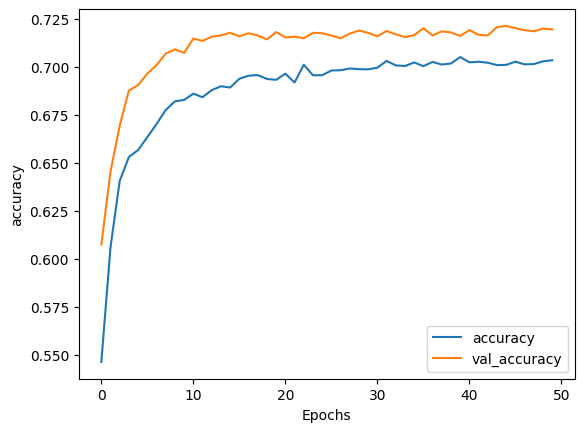

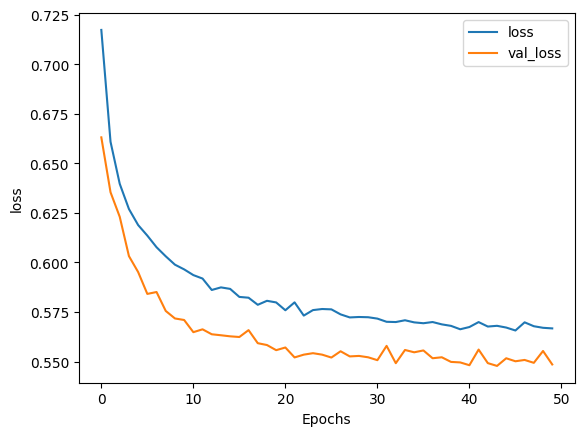

In [58]:
h = model.fit(training_sentences, training_label, epochs=50,
              validation_data=(test_sentences, test_label),
              callbacks=[model_ckp])

plot_graphs(h, 'accuracy')
plot_graphs(h, 'loss')